In [216]:
# @title Autor: Alan Echer
# O algoritmo abaixo foi criado baseado nas funcoes apreendidas na aula de
# IA e machine learning do INFNET

# passos para fazer ao analisar os dados
#adicionar dependencias
#carregar os dados dos dataset
#analisar de dados
#normalizar dados das colunas
#verificar dados nullos
#verificar dados categoricos
#verificar representatividade dos dados do objetivo em relação ao restante dos dados
#(objetivo = 1, restante = 0)
#normalizar os dados
#verificar separabilidade linear
#separar os dados treino / teste estratificando
#definir o baseline otimista / pessimista
#gerar os dados estatisticos
#otimizacao verificar os falsos positivos e falsos negativos em funcao do limiar minimo
#otimizacao verificar o precisao e recall em funcao do limiar minimo
#otimizacao verificar curva ROC vs classificador aleatorio
#otimizacao lucro medio em relacao ao limiar minimo
#gerar o modelo e os dados estatisticos
#comparar com os modelos otimista e pessimistas

In [217]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.metrics import confusion_matrix
from google.colab import drive

In [218]:
# esta variavel mantem o cache do dataset que foi carregado do gdrive
# para evitar carregar toda vez os dados
# caso precise carregar novamente os dados só rode este bloco e o cache será limpo
cache = {
    'dataset':None,
    'original_data_before_transformation':{},
    'original_data_before_drop':{},
}

In [219]:
def loadAnaliseAndTransformData(cache, configuration, y_column):
  data = loadDataSetFromGDriveOrCache(cache, configuration)

  reAddDroppedColumnsBefore(configuration, cache, data)

  if(configuration['dataset']['normalize_columns']['enabled']):
    print()
    print('=> Normalizing column names...')
    normalizeColumnNames(configuration, data)
    print('=> Normalizing column names... OK')

  transformData(configuration, cache, data)

  if(configuration['drop_columns']['enabled']):
    print()
    print('Dropping columns...')
    dropColumns(configuration, cache, data)
    print('Dropping columns... OK')

  if(configuration['dataset']['show_data']['enabled']):
    showDataInfo(configuration, data)

  if(configuration['pair_plot']['enabled']):
    print()
    print('=> Plotting pair plot...')
    plotPairPlot(configuration, data)
    print('=> Plotting pair plot... OK')

  generateConfusionMatrix(y_column, data)

  return data

def loadDataSetFromGDriveOrCache(cache, configuration):
  if(cache['dataset'] is None):
    if(configuration['dataset']['source_provider'] == 'gdrive'):
      print('=> Mounting google drive...')
      drive.mount('/content/drive')
      print('=> Mounting google drive... OK')
    else:
      print('=> ERROR: Source provider not supported: '+configuration['dataset']['source_provider'])
      return

    if(configuration['dataset']['reader_type'] == 'csv'):
      print()
      print('=> Reading csv data...')
      cache['dataset'] = pd.read_csv('/content/drive/MyDrive/'+configuration['dataset']['path'], sep=configuration['dataset']['sep'])
      print('=> Reading csv data... OK')
      return cache['dataset']
    else:
      print('=> ERROR: Reader type not supported: '+configuration['dataset']['reader_type'])
      return
  else:
    print()
    print('=> Using cached dataset... OK')
  return cache['dataset']

def showDataInfo(configuration, data):
  if(configuration['dataset']['show_data']['dataset_head']):
    print()
    print('=> Dataset head: ')
    print(data.head())

  if(configuration['dataset']['show_data']['dataset_info']):
    print()
    print('=> Dataset info: ')
    print(data.info())

  if(configuration['dataset']['show_data']['dataset_describe']):
    print()
    print('=> Dataset describe: ')
    print(data.describe())

  if(configuration['dataset']['show_data']['dataset_nulls']):
    print()
    print('=> Dataset nulls: ')
    print(data.isnull().sum())

  if(configuration['dataset']['show_data']['dataset_duplicated']):
    print()
    print('=> Dataset duplicated: ')
    print(data.duplicated().sum())

  if(configuration['dataset']['show_data']['dataset_unique_values']):
    print()
    print('=> Dataset unique values: ')
    for column in data.columns:
      print()
      print('Column: '+column, data[column].unique())

  if(configuration['dataset']['show_data']['dataset_value_counts']):
    print()
    print('=> Dataset value counts: ')
    for column in data.columns:
      print()
      print('Column: ', data[column].value_counts(normalize=True))
  pass

def transformData(configuration, cache, data):
  for transformation in configuration['data_transformation']['transformations']:
    columnName = transformation['column']
    #backup original data column for cenarios where you need to run transformation multiple times
    #and not want to loose original data
    cachedColumns = cache['original_data_before_transformation']
    if(not transformation['enabled']):
      if(cachedColumns.get(columnName) is not None):
        data[columnName] = cachedColumns[columnName]
      continue
    print()
    print()
    print('=> Applying data transformations...')
    if(cachedColumns.get(columnName) is None):
      cachedColumns[columnName] = data[columnName]
    data[columnName] = cachedColumns[columnName].apply(transformation['function'])
    print('=> Applying data transformations... OK')
  pass

def normalizeColumnNames(configuration, data):
  normalize = configuration['dataset']['normalize_columns']
  if(normalize['modificator'] == 'lower'):
    data.columns = data.columns.str.lower()
  elif(normalize['modificator'] == 'upper'):
    data.columns = data.columns.str.upper()
  else:
    print('=> ERROR: modificator unsuported!')
  for column in data.columns:
    for replacement in normalize['replacements']:
      data[column] = data[column].replace(replacement['char_to_replace'], replacement['replace_with'])
  pass

def reAddDroppedColumnsBefore(configuration, cache, data):
  columns = []
  for column in cache['original_data_before_drop']:
    if(cache['original_data_before_drop'].get(column) is not None):
      print()
      print('=> Recriando coluna previamente deletada: ', column)
      data[column] = cache['original_data_before_drop'][column]
      columns.append(column)
      print('=> Recriando coluna previamente deletada... OK')
  for column in columns:
     print()
     print('=> Apagando coluna restaurada do cache: ', column)
     del cache['original_data_before_drop'][column]
     print('=> Apagando coluna restaurada do cache... OK')
  pass

def dropColumns(configuration, cache, data):
  for column in configuration['drop_columns']['columns']:
    cache['original_data_before_drop'][column] = data[column]
  return data.drop(columns=configuration['drop_columns']['columns'], inplace=True)

def plotPairPlot(configuration, data):
  if(configuration['pair_plot']['type'] == '2d'):
    hue = hue=configuration['pair_plot']['hue_column']
    if(configuration['pair_plot']['columns'] == 'all'):
      sns.pairplot(data=data, hue=hue)
    elif (configuration['pair_plot']['columns'] == 'selection'):
      selection = configuration['pair_plot']['selection']
      data_to_plot = data.loc[:,selection]
      sns.pairplot(data=data_to_plot, hue=hue)
  else:
    print('=> ERROR: Pair plot type not supported: '+configuration['pair_plot']['type'])
    return
  pass

def generateConfusionMatrix(y_column, data):
  unique_values = data[y_column].unique()
  if(len(unique_values) == 2):
    if((unique_values[0] == 1 or unique_values[0] == 0) and (unique_values[1] == 1 or unique_values[1] == 0)):
      y_optimist = [0] * len(data[y_column])
      y_pessimist = [1] * len(data[y_column])
      print()
      print('=> Imprimindo matriz de confusão otimista (0)')
      printConfusionMatrix(y_optimist, data)
      print()
      print('=> Imprimindo matriz de confusão pessimista (1)')
      printConfusionMatrix(y_pessimist, data)
    else:
      print('=> ERROR: Y column has following values: ', unique_values)
      print('=> ERROR: Y column must contain only two values: 0, 1')
  else:
    print('=> ERROR: Y column has following values: ', unique_values)
    print('=> ERROR: Y column must contain only two values: 0, 1')
  pass

def printConfusionMatrix(y_optimist, data):
  sns.heatmap(confusion_matrix(data[y_column], y_optimist), annot=True, fmt='g')
  #plt.figure(figsize = (1,0))
  plt.title('Matriz de confusão')
  plt.xlabel('Saida do Modelo')
  plt.ylabel('Saida esperada')
 # plt.annotate('teste',xy=(0,0), ha='center', va='center')
  plt.show()
  pass


=> Mounting google drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=> Mounting google drive... OK

=> Reading csv data...
=> Reading csv data... OK

=> Normalizing column names...
=> Normalizing column names... OK


=> Applying data transformations...
=> Applying data transformations... OK

=> Dataset head: 
   age sex      bp cholesterol  na_to_k  drug
0   23   F    HIGH        HIGH   25.355     0
1   47   M     LOW        HIGH   13.093     1
2   47   M     LOW        HIGH   10.114     1
3   28   F  NORMAL        HIGH    7.798     0
4   61   F     LOW        HIGH   18.043     0

=> Imprimindo matriz de confusão otimista (0)


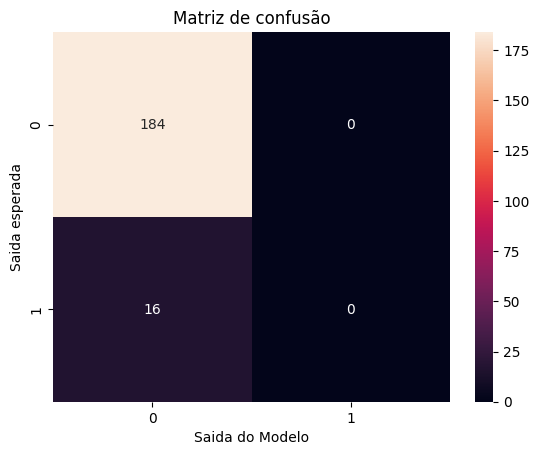


=> Imprimindo matriz de confusão pessimista (1)


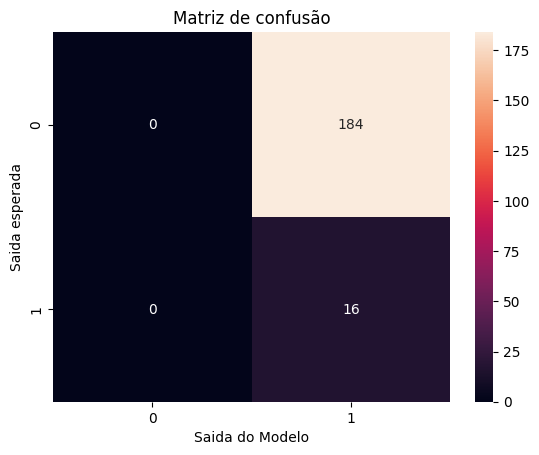

In [220]:
#configuracao inicial

y_column = 'drug'

configuration = {
    'dataset':{
        'source_provider':'gdrive',# only supported google drive
        'reader_type':'csv',# only supported csv
        'path':'ALGORITMOS DE IA/DATASET/drug200.csv',# CAMINHO PARA O SEU DATASET NO GDRIVE
        'sep':',',# SEPARADOR DOS DADOS DO SEU DATASET, POR EX: , OU ; OU OUTRO
        'normalize_columns':{# SECAO PARA CONFIGURACAO DA NORMALIZACAO DAS COLUNAS
            'enabled':True,
            'modificator': 'lower',# ALLOWED ONLY 'lower' or 'upper' value
            'replacements':[
                {
                    'char_to_replace':' ',
                    'replace_with':'_'
                },
                {
                    'char_to_replace':'(',
                    'replace_with':''
                },
                {
                    'char_to_replace':')',
                    'replace_with':''
                },
            ]
        },
        'show_data':{# SECAO PARA CONFIGURACAO DOS LOGS
            'enabled':True,
            'dataset_head':True,
            'dataset_info':False,
            'dataset_describe':False,
            'dataset_nulls':False,
            'dataset_duplicated':False,
            'dataset_unique_values':False,
            'dataset_value_counts':False,
        },
    },
    'data_transformation':{ #SECAO PARA CONFIGURACAO DA TRANSFORMACAO DOS DADOS
        'transformations':[
            {
                'enabled':False,
                'column':'sex',
                'function':lambda r:1 if r == 'M' else 0
            },
            {
                'enabled':True,
                'column':'drug',
                'function':lambda r:1 if r == 'drugC' else 0
            },
        ]
    },
    'drop_columns':{
        'enabled':False,
        'columns':['sex', 'bp']
    },
    'pair_plot':{
        'enabled':False,
        'type':'2d', # only 2d available
        'columns':'all', # all or selection
        'selection':['age','sex', 'na_to_k', y_column],# or add specific columns here, remember to add hue_column value here too
        'hue_column':y_column,
    }
}

data = loadAnaliseAndTransformData(cache, configuration, y_column)